In [25]:
import torch
from torch import nn, optim
import torch_directml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sklearn
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from helper_functions import plot_predictions, plot_decision_boundary, accuracy_fn
print(torch.__version__)
if torch_directml.is_available():
    device = torch_directml.device()
else:
    device = torch.device("cpu")
print(device)

2.4.1+cpu
privateuseone:0


In [30]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42
X, Y = make_blobs(n_samples=1000,
                  centers=NUM_CLASSES,
                  n_features=NUM_FEATURES,
                  cluster_std=1.5,
                  random_state=RANDOM_SEED)

In [31]:
X = torch.from_numpy(X).type(torch.float)
Y = torch.from_numpy(Y).type(torch.LongTensor)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=RANDOM_SEED)

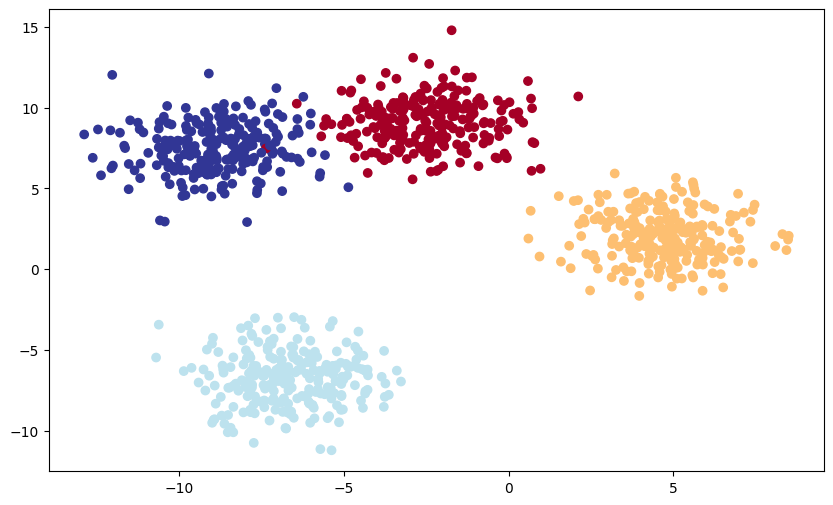

In [32]:
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.RdYlBu)

In [72]:
class BModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.h1 = nn.Linear(2, 8)
        self.h2 = nn.Linear(8, 16)
        self.h3 = nn.Linear(16, 8)
        self.h4 = nn.Linear(8, 4)
        self.relu = nn.ReLU()   

    def forward(self,x):
        return self.h4(self.relu(self.h3(self.relu(self.h2(self.relu(self.h1(x)))))))

In [73]:
model0 = BModel()
model0.state_dict()

OrderedDict([('h1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998]])),
             ('h1.bias',
              tensor([ 0.5451,  0.1045, -0.3301,  0.1802, -0.3258, -0.0829, -0.2872,  0.4691])),
             ('h2.weight',
              tensor([[-0.2791, -0.1630, -0.0998, -0.2126,  0.0334, -0.3492,  0.3193, -0.3003],
                      [ 0.2730,  0.0588, -0.1148,  0.2185,  0.0551,  0.2857,  0.0387, -0.1115],
                      [ 0.0950, -0.0959,  0.1488,  0.3157,  0.2044, -0.1546,  0.2041,  0.0633],
                      [ 0.1795, -0.2155, -0.3500, -0.1366, -0.2712,  0.2901,  0.1018,  0.1464],
                      [ 0.1118, -0.0062,  0.2767, -0.2512,  0.0223, -0.2413,  0.1090, -0.1218],
     

In [74]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model0.parameters(), lr=0.1)

In [75]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

In [76]:
epochs = 0
loss_train = []
loss_test = []


In [77]:
for _ in range(100):
    model0.train()
    y_logits = model0(X_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_train.append(loss.item())
    model0.eval()
    with torch.inference_mode():
        test_logits = model0(X_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        test_loss = loss_fn(test_logits, y_test) 
        test_acc = accuracy_fn(y_test, test_pred)
        loss_test.append(test_loss.item())
    epochs += 1
    
    print(f"Epoch: {epochs} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 1 | Loss: 1.47269, Acc: 5.75% | Test Loss: 1.43981, Test Acc: 4.50%
Epoch: 2 | Loss: 1.42022, Acc: 6.38% | Test Loss: 1.40958, Test Acc: 8.00%
Epoch: 3 | Loss: 1.39136, Acc: 8.50% | Test Loss: 1.38925, Test Acc: 11.50%
Epoch: 4 | Loss: 1.37208, Acc: 14.88% | Test Loss: 1.37071, Test Acc: 21.00%
Epoch: 5 | Loss: 1.35428, Acc: 25.37% | Test Loss: 1.35674, Test Acc: 26.00%
Epoch: 6 | Loss: 1.34021, Acc: 28.12% | Test Loss: 1.34163, Test Acc: 27.00%
Epoch: 7 | Loss: 1.32479, Acc: 28.88% | Test Loss: 1.32461, Test Acc: 26.50%
Epoch: 8 | Loss: 1.30752, Acc: 28.62% | Test Loss: 1.30784, Test Acc: 26.50%
Epoch: 9 | Loss: 1.29050, Acc: 28.12% | Test Loss: 1.29126, Test Acc: 26.50%
Epoch: 10 | Loss: 1.27391, Acc: 27.62% | Test Loss: 1.27421, Test Acc: 26.50%
Epoch: 11 | Loss: 1.25697, Acc: 27.38% | Test Loss: 1.25698, Test Acc: 26.00%
Epoch: 12 | Loss: 1.24019, Acc: 27.25% | Test Loss: 1.23987, Test Acc: 26.00%
Epoch: 13 | Loss: 1.22386, Acc: 27.38% | Test Loss: 1.22335, Test Acc: 26.50%


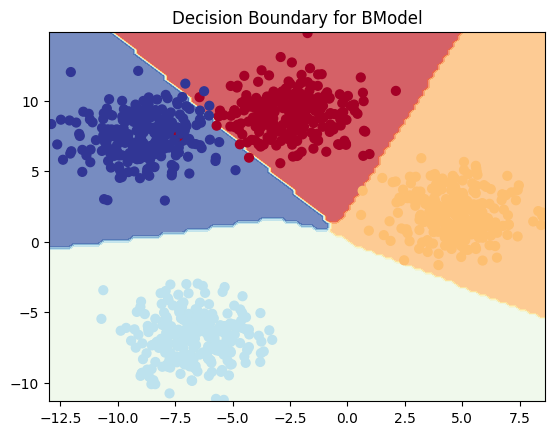

In [78]:
plot_decision_boundary(model0, X, Y)
plt.title("Decision Boundary for BModel")
plt.show()

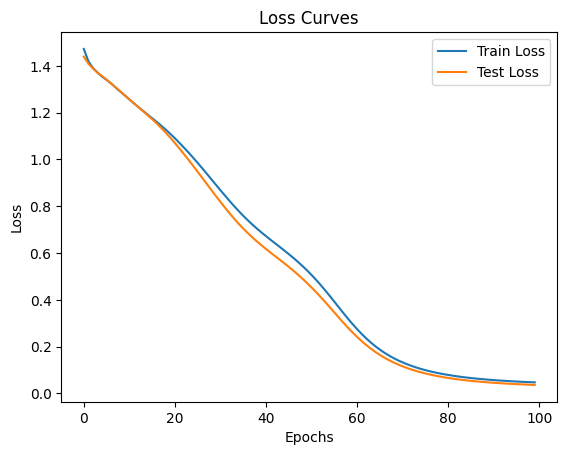

In [79]:
plt.plot(range(epochs), loss_train, label="Train Loss")
plt.plot(range(epochs), loss_test, label="Test Loss")
plt.title("Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()